In [7]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
from time_series.preprocessing.generate_dataset import Offsets
from time_series.preprocessing.generate_dataset import MakeDatasetFromDataFrame
from tensorflow.data import Dataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create univariate time series
- from coursera course *sequences, time series and prediction*
- **Dense Neural Networks** 
    - Single layer
    - Multi layer
    
- **Recurrent Neural Networks**
    - Also illustrate learnin rate scanning via callbacks
    
- **LSTM**

- **1D Convolutional Neural Networks** 
    - in combination with LSTM (Hybrid Model)

### Conclusions
- For this simple dataset a single neural network performs extraordinary well. 
- It is hard to compeed with more sophisticated approaches
- The plots below clearly shot that the more sophisticated models overfit. 
- So more work on regularization or more data is desireable

In [8]:
def plot_series(time, series, model_series=None, mse=None):
    fig, ax = plt.subplots(figsize=(15,3))
    start = 0
    end = None
    ax.plot(time[start:end], series[start:end],  color="red", alpha=.4, label="time series")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)
    if model_series is not None:
        label = "forecast"
        if mse:
            rounded_mse = np.round(mse, 2)
            label = label + " (mse={mse})".format(mse=rounded_mse)
        ax.plot(time[start:end], model_series[start:end],  color="black", alpha=.4, label=label)
        ax.legend()
        
        

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def create_time_series():
    time = np.arange(4 * 365 + 1, dtype="float32")
    baseline = 10
    series = trend(time, 0.1)  
    baseline = 10
    amplitude = 40
    slope = 0.05
    noise_level = 5
    # Create the series
    series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
    # Update with noise
    series += noise(time, noise_level, seed=42)
    return pd.DataFrame({"y": series})

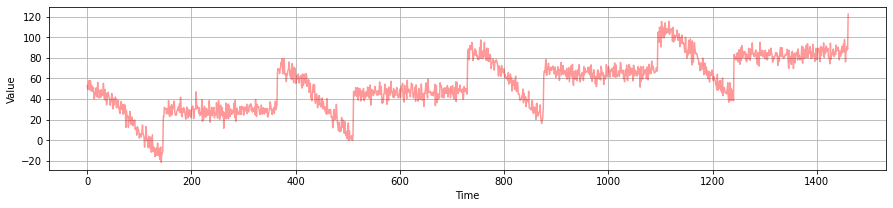

In [9]:
df = create_time_series()
plot_series(df.index, df.y)

### Split train and test set and parametrize time series
- In this notebook we don't use a validation set. 
- Just train and test data

In [10]:
offsets = Offsets(input_width=20, label_width=1) # parametrize
split_time = 1000
train = df[:split_time]
test = df[split_time - offsets.sequence_width:] 

# get time ranges for preditions on test data
test_time_range = range(test.index.start + offsets.sequence_width, test.index.stop + 1)

### Create tensorflow dataset

In [11]:
train_ds = MakeDatasetFromDataFrame(offsets=offsets, batch_size=32, labels=["y"], shuffle_buffer_size=1000)(train)
test_ds = MakeDatasetFromDataFrame(offsets=offsets, batch_size=32, labels=["y"], shuffle_buffer_size=None)(test)

# Check shape of the first training batch
for x, y in train_ds.take(1):
    print(f"Input shape {x.shape}")
    print(f"Label shape {y.shape}")    

Input shape (32, 20, 1)
Label shape (32, 1, 1)


### Create models 
- before specifiying the actual model we write some convenience functions in order to easy compareing multiple models


In [12]:
def compile_and_fit(model, 
                    train_data:Dataset, 
                    validation_data: Dataset, 
                    loss = tf.losses.MeanSquaredError(),
                    epochs=100,
                    optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), 
                    callbacks: list=[], 
                    metrics: list=[]):
    
    print(model.summary())
    model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)

    history = model.fit(train_data, epochs=epochs,
                      validation_data=validation_data,
                      verbose=0,
                      callbacks=callbacks)
    return history

def apply_model(model, test: Dataset):
    y_pred = model.predict(test)
    y_pred = y_pred.flatten()
    # extract labels into array
    y_true = tf.concat([batch for batch in test.map(lambda feature, label: label)], axis=0)
    y_true = y_true.numpy().flatten() 
    mse = tf.keras.metrics.mean_absolute_error(y_true, y_pred).numpy()
    return y_true, y_pred,  mse


def plot_training(history, xlim=None, ylim=None):
    fig, ax = plt.subplots(figsize=(15,3))
    ax.plot(history.history["loss"], color="red", alpha=.4, label="Training")
    ax.plot(history.history["val_loss"], color="black", alpha=.4, label="Valdiaton")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.grid()
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    ax.legend()
  

def plot_learning_rate(history, xlim=None, ylim=None, text=None):
    """Plot loss vs learning rate. Only works if lr scheduler has been invoked"""
    fig, ax = plt.subplots(figsize=(15,3))
    label = "Training"
    if text:
        label = label + " " + text
    ax.semilogx(history.history["lr"], history.history["loss"], color="black", label=label)
    ax.set_xlabel("Learning rate")
    ax.set_ylabel("Loss")
    ax.grid()
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    ax.legend()  

### Single layer Neural Network

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
_________________________________________________________________
reshape (Reshape)            (None, 1, 1)              0         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
None


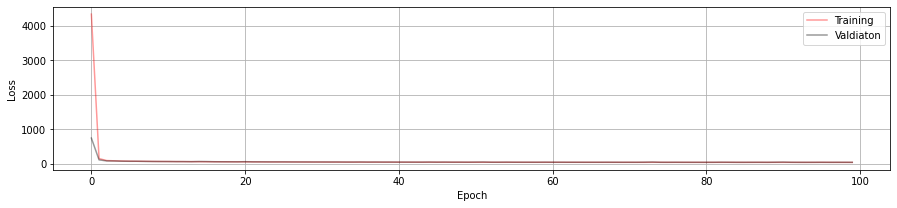

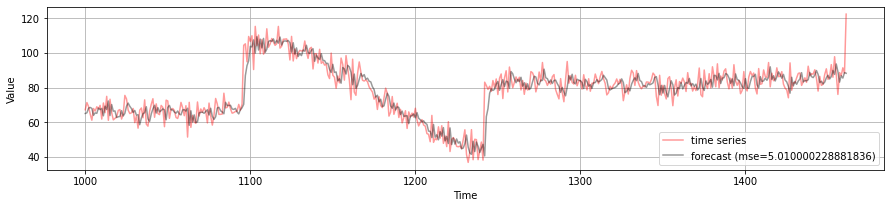

In [13]:
from tensorflow.keras.models import Sequential
tf.keras.backend.clear_session()

# flattening is induced by the more general shape of the data that could also include more features
# similar the reshape layer
model = Sequential([tf.keras.Input(shape=(offsets.input_width, 1)),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(units=1), 
                    tf.keras.layers.Reshape([1, -1])])

history = compile_and_fit(model, train_ds, test_ds, epochs=100)
plot_training(history)
plot_series(test_time_range, *apply_model(model, test_ds))

### Multi layer Neural Network

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
_________________________________________________________________
reshape (Reshape)            (None, 1, 1)              0         
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
None


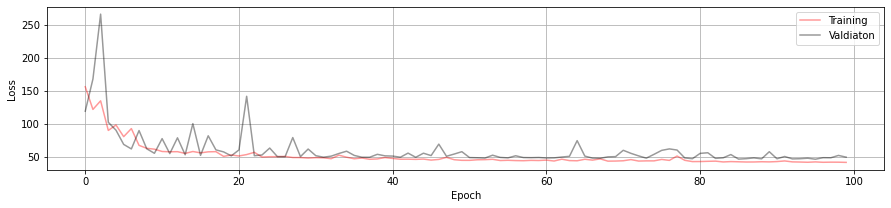

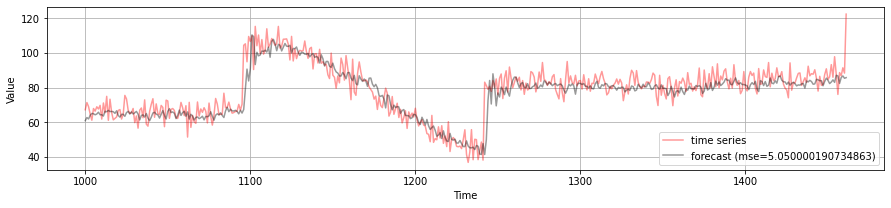

In [14]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(offsets.input_width, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
    tf.keras.layers.Reshape([1, -1])
])

history = compile_and_fit(model, train_ds, test_ds, epochs=100)
plot_training(history)
plot_series(test_time_range, *apply_model(model, test_ds))

### Sequence modelling with Recurrent Neural Networks
- In principle we have **sequence-to-sequence** and **sequence-to-vector** archititectures 
    - In a **sequence-to-sequence** architecture each recurrent unit gives the hidden state as output
    - The indivual outputs can be sent to further layers. And these share weights along all hidden state ouput. 
    - In a **sequence-to-vector** architecture only the last recurrent unit gives the (hidden) state as output.
- In this context *sequence-to-sequence* architectures can be used upon stacking recurrent units. 
- In tensorflow this befhavior is controlled by the flag `return_sequences`:
    - `return_sequences = True`: sequence-to-sequence
    - `return_sequences = False`: sequence-to-vector
    

**Shape**
- The input shape for an RNN needs to be `(batch, time, feature)`
- This is already provided by the class `MakeDatasetFromDataFrame` used in this notebook.

**Vanishing Exloding Gradient Problem** 
- Is a known issue with RNNs
- This implies that training RNNs is a really flaky business
- This is one reason to use LSTMs
- So rerunning the notebook eventually yields very much different results!

In [37]:
model = tf.keras.models.Sequential([
    # Sample of a batch has dimension "(time, features)". 
    # For arbritary input times this is (None, 1)
    tf.keras.Input(shape=(None, 1)), 
    # RNN with hidden state dimension 10. 
    # As we are using stacked RNNs the first RNN layer is sequence to sequence (return_sequences=True)
    tf.keras.layers.SimpleRNN(10, return_sequences=True, name="layer_1_rnn"),
    # Sequence to vector RNN with hidden state dimension 10
    tf.keras.layers.SimpleRNN(10,  return_sequences=False, name="layer_2_rnn"),
    tf.keras.layers.Dense(1, name="layer2_dense"),
    # scale output to bring it in prediction order as we rnn have tanh activation
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1_rnn (SimpleRNN)      (None, None, 10)          120       
_________________________________________________________________
layer_2_rnn (SimpleRNN)      (None, 10)                210       
_________________________________________________________________
layer2_dense (Dense)         (None, 1)                 11        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________
None


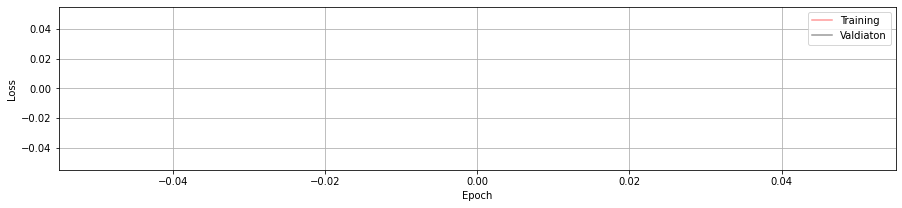

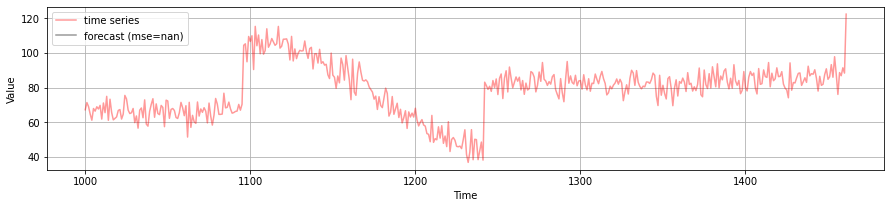

In [40]:
tf.keras.backend.clear_session()

history = compile_and_fit(model, train_ds, test_ds, epochs=100)
plot_training(history)
plot_series(test_time_range, *apply_model(model, test_ds))

* This **prediction is really bad** (compared to the other ones).
* In particular the test set does not seem to converge w.r.t training loss function. 
* Since RNN are prone to outliers we use a more robust loss, the **Huber loss**. 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1_rnn (SimpleRNN)      (None, None, 10)          120       
_________________________________________________________________
layer_2_rnn (SimpleRNN)      (None, 10)                210       
_________________________________________________________________
layer2_dense (Dense)         (None, 1)                 11        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________
None


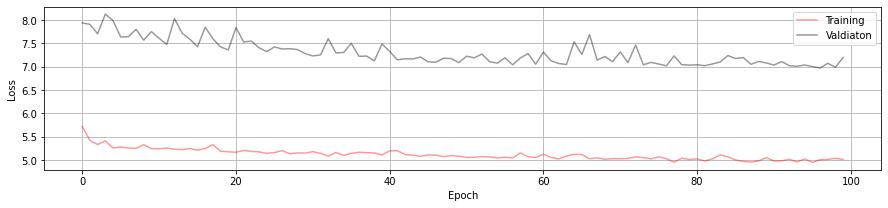

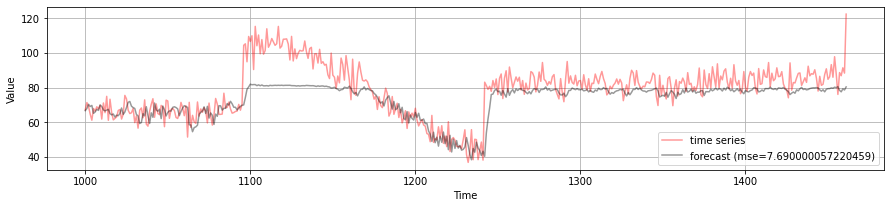

In [13]:
history = compile_and_fit(model, train_ds, test_ds, epochs=100, loss=tf.keras.losses.Huber())
plot_training(history)
plot_series(test_time_range, *apply_model(model, test_ds))

* Better!
* Let's look at the training behavior in more detail

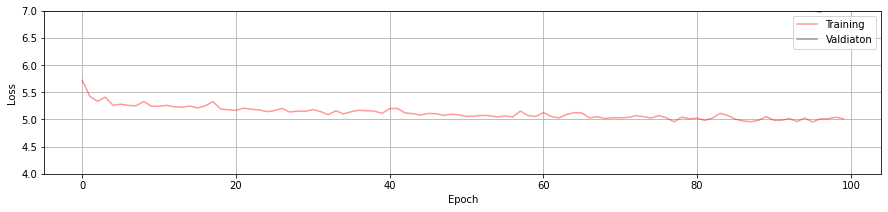

In [14]:
plot_training(history, ylim=(4, 7))

### Exkursion Hyper parameter tuning (learning rate)
- we have oscillations, indicating that the optimizer is not performing well. 
- So we can look at the learning rate and find it's sweet spot.
- Also also look at this as a function of training batch size
- The learning rate can be changed in keras via a callback function `tf.keras.callbacks.LearningRateScheduler`  

In [18]:
tf.keras.backend.clear_session()
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

def wrapper(batch_size): 
    train_ds = MakeDatasetFromDataFrame(offsets=offsets, batch_size=batch_size, labels=["y"], shuffle_buffer_size=1000)(train)
    history = compile_and_fit(model, 
                              train_ds, 
                              test_ds, 
                              epochs=100, 
                              loss=tf.keras.losses.Huber(), 
                              callbacks=[lr_scheduler])
    return history
    
histories={}
for batch_size in [16, 32, 64, 128, 256]:
    histories.update({batch_size: wrapper(batch_size)})

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1_rnn (SimpleRNN)      (None, None, 10)          120       
_________________________________________________________________
layer_2_rnn (SimpleRNN)      (None, 10)                210       
_________________________________________________________________
layer2_dense (Dense)         (None, 1)                 11        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1_rnn (SimpleRNN)      (None, None, 10)          120       
_________________________________

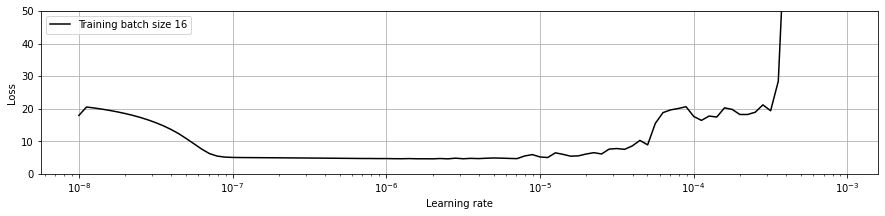

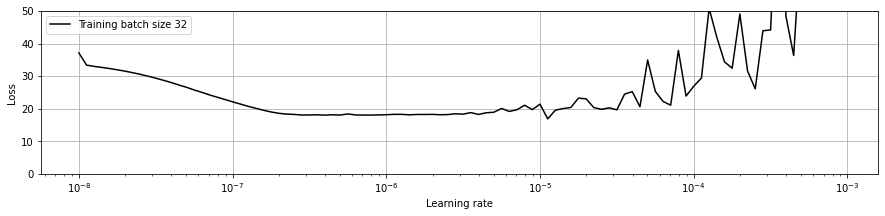

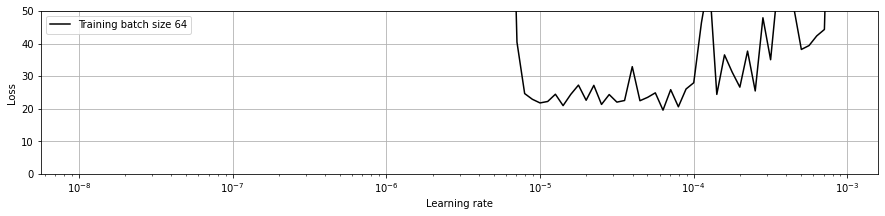

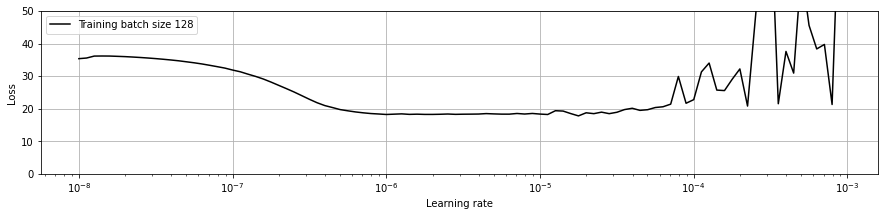

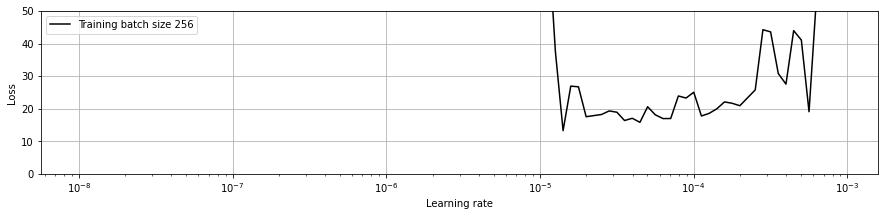

In [19]:
plot_learning_rate(histories[16], text="batch size 16", ylim=(0,50))
plot_learning_rate(histories[32], text="batch size 32", ylim=(0,50))
plot_learning_rate(histories[64], text="batch size 64", ylim=(0,50))
plot_learning_rate(histories[128], text="batch size 128", ylim=(0,50))
plot_learning_rate(histories[256], text="batch size 256", ylim=(0,50))

- at the original batch size of 32 the default learning rate of $10^{-6}$ seems to be okay
- so the learning rate does not improve things much. 
- Training is complicated for RNNs! 
- So we switch to LSTM

In [17]:
train_ds = MakeDatasetFromDataFrame(offsets=offsets, batch_size=32, labels=["y"], shuffle_buffer_size=1000)(train)

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(None, 1)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
]) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________
None


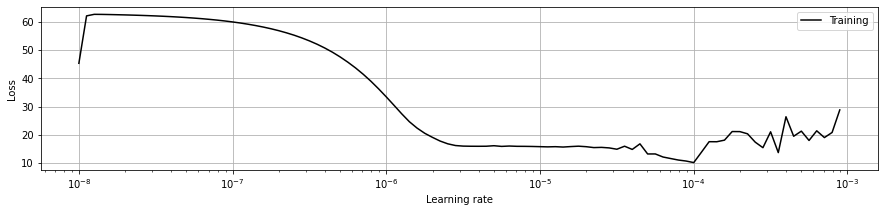

In [19]:
# find optimal learning rate first
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
history = compile_and_fit(model, 
                          train_ds, 
                          test_ds, 
                          epochs=100, 
                          loss=tf.keras.losses.Huber(), 
                          callbacks=[lr_scheduler])
plot_learning_rate(history)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________
None


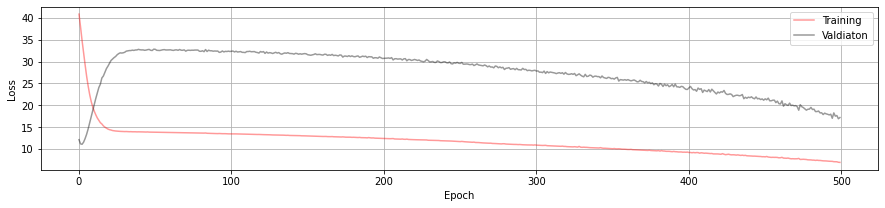

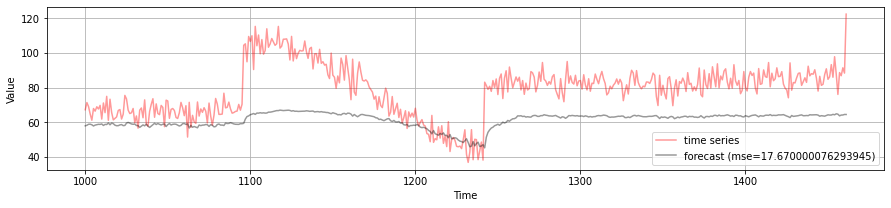

In [20]:
# apply model with optimal learning rate of 10**-5 with 500 epochs
history = compile_and_fit(model, 
                          train_ds, 
                          test_ds, 
                          epochs=500, 
                          loss=tf.keras.losses.Huber(), 
                          optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
plot_training(history)
plot_series(test_time_range, *apply_model(model, test_ds))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 58,433
Trainable params: 58,433
Non-trainable params: 0
_________________________________________________________________
None


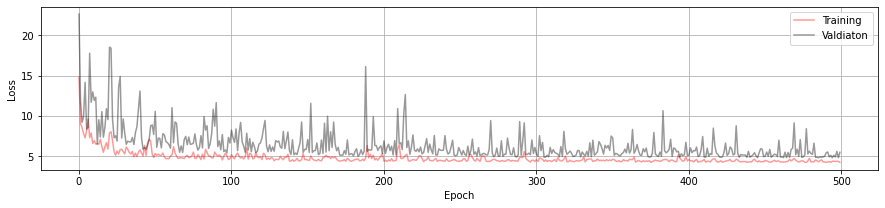

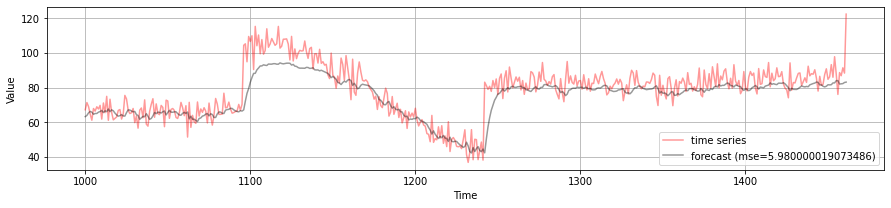

In [24]:
# Make a more complex model by adding one more LSTM layer

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(None, 1)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
]) 

history = compile_and_fit(model, 
                          train_ds, 
                          test_ds, 
                          epochs=500, 
                          loss=tf.keras.losses.Huber(), 
                          optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9))
plot_training(history)
plot_series(test_time_range, *apply_model(model, test_ds))

- Adding a layer layer improves things considerably.
- However, the performance is still worse than the single layer NN. 
- Also, there is some overfitting. Let's try to reduce this by regularization. 
- We also observe unhealty spikes in the training curve.
- Both effects can be tackled by reducing the batch size 
- We will reduce the batch size to 8

In [28]:
train_ds = MakeDatasetFromDataFrame(offsets=offsets, batch_size=8, labels=["y"], shuffle_buffer_size=1000)(train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          128       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_________________________________________________________________
None


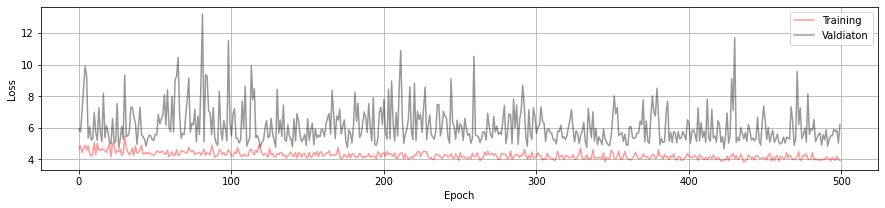

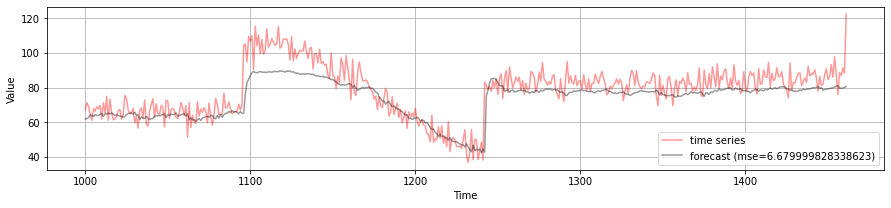

In [30]:
history = compile_and_fit(model, 
                          train_ds, 
                          test_ds, 
                          epochs=500, 
                          loss=tf.keras.losses.Huber(), 
                          optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9))
plot_training(history)
plot_series(test_time_range, *apply_model(model, test_ds))

### Convolutional layers

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          128       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_________________________________________________________________
None


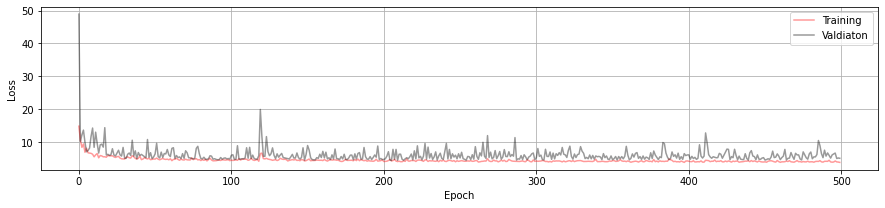

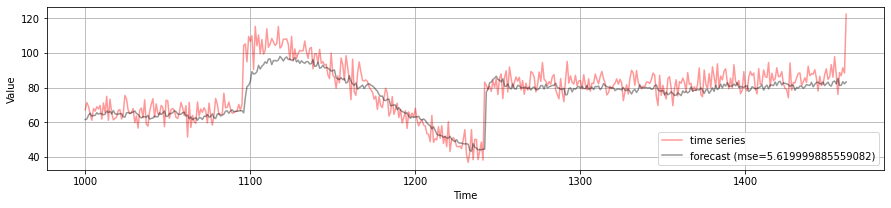

In [31]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(None, 1)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                           strides=1, padding="causal",
                           activation="relu"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

history = compile_and_fit(model, 
                          train_ds, 
                          test_ds, 
                          epochs=500, 
                          loss=tf.keras.losses.Huber(), 
                          optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9))
plot_training(history)
plot_series(test_time_range, *apply_model(model, test_ds))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          128       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 25,121
Trainable params: 25,121
Non-trainable params: 0
____________________________________________________

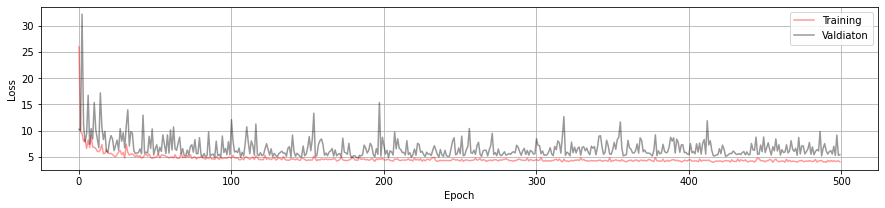

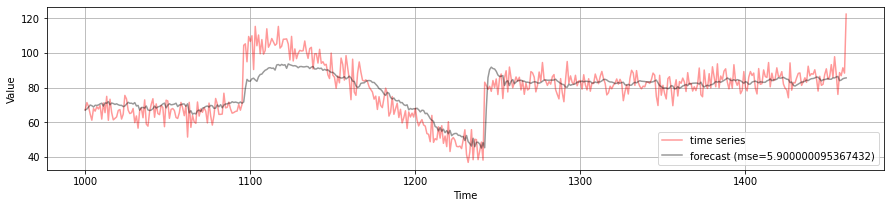

In [32]:
# all in - add another lstm layer
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(None, 1)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                           strides=1, padding="causal",
                           activation="relu"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

history = compile_and_fit(model, 
                          train_ds, 
                          test_ds, 
                          epochs=500, 
                          loss=tf.keras.losses.Huber(), time_series_tutorioal_from_tensor_flow
                          optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9))
plot_training(history)
plot_series(test_time_range, *apply_model(model, test_ds))